In [6]:
import numpy as np
import pandas as pd
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout

import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score,f1_score,classification_report, confusion_matrix, precision_recall_curve, roc_curve,roc_auc_score


df_full = pd.read_csv('creditcard.csv')

print(df_full.head(5))


   Time        V1        V2        V3        V4  ...       V26       V27       V28  Amount  Class
0     0 -1.359807 -0.072781  2.536347  1.378155  ... -0.189115  0.133558 -0.021053  149.62    0.0
1     0  1.191857  0.266151  0.166480  0.448154  ...  0.125895 -0.008983  0.014724    2.69    0.0
2     1 -1.358354 -1.340163  1.773209  0.379780  ... -0.139097 -0.055353 -0.059752  378.66    0.0
3     1 -0.966272 -0.185226  1.792993 -0.863291  ... -0.221929  0.062723  0.061458  123.50    0.0
4     2 -1.158233  0.877737  1.548718  0.403034  ...  0.502292  0.219422  0.215153   69.99    0.0

[5 rows x 31 columns]


In [8]:
print(df_full.Class.value_counts())
df_full.sort_values(by='Class',ascending=False,inplace=True)

0.0    116697
1.0       244
Name: Class, dtype: int64


In [9]:
df_full.drop('Time',axis=1,inplace=True)

In [10]:
df_sample = df_full.iloc[:3000,:]
print(df_sample.Class.value_counts())
shuffle_df = shuffle(df_sample,random_state=42)

0.0    2756
1.0     244
Name: Class, dtype: int64


**Split** **the dataset into train and test**

In [11]:
df_train = shuffle_df[0:2500]
df_test = shuffle_df[2500:]

**Split each dataset into feature and label**

In [15]:
train_feature = np.array(df_train.values[:, 0:29])
train_label = np.array(df_train.values[:, -1])
test_feature = np.array(df_test.values[:, 0:29])  # Corrected indexing here
test_label = np.array(df_test.values[:, -1])
print(train_feature.shape)
print(train_label.shape)


(2500, 29)
(2500,)


**Standardize the features columns to increase training speed**

In [16]:
scaler = MinMaxScaler()
scaler.fit(train_feature)
train_feature_trans = scaler.transform(train_feature)
test_feature_trans = scaler.transform(test_feature)

**Function to train plot the learning curves**

In [33]:
def show_train_history(train_history,train,validation):
  plt.plot(train_history.history[train])
  plt.plot(train_history.history[validation])
  plt.title('Train History')
  plt.ylabel(train)
  plt.xlabel('Epoch')
  plt.legend(['train','validation'], loc='upper left')


**Constructing the CNN and training phase,**

---

**Select the type of model**

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 200)               6000      
                                                                 
 dropout_18 (Dropout)        (None, 200)               0         
                                                                 
 dense_28 (Dense)            (None, 200)               40200     
                                                                 
 dropout_19 (Dropout)        (None, 200)               0         
                                                                 
 dense_29 (Dense)            (None, 1)                 201       
                                                                 
Total params: 46401 (181.25 KB)
Trainable params: 46401 (181.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/20

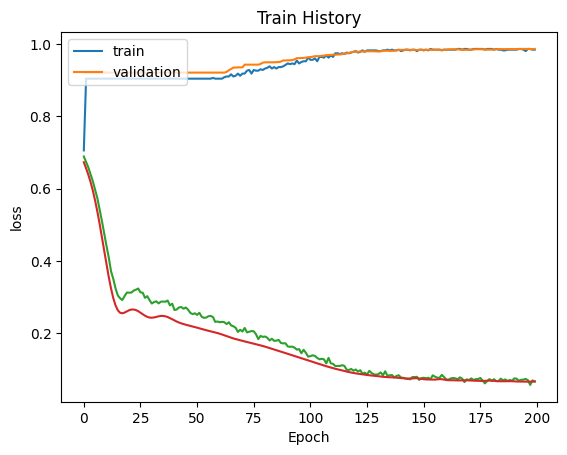

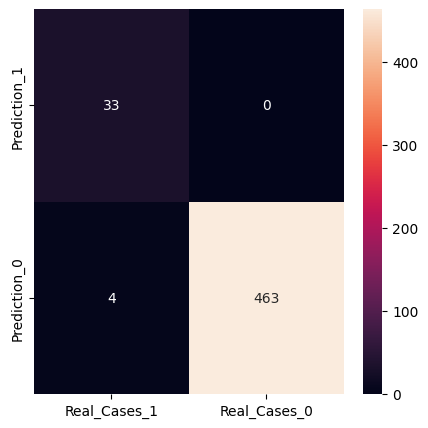

Total numbers of test cases:  500


In [34]:
model = Sequential()


#Add first Dense layer with 200 neurons and ReLu activation function
model.add(Dense(units=200,
                input_dim=29,
                kernel_initializer='uniform',
                activation='relu'))

#Add Dropout to prevent overfitting
model.add(Dropout(0.5))

#Add second Dense layer with 200 neurons units and ReLu activation function
model.add(Dense(units=200,
                input_dim=29,
                kernel_initializer='uniform',
                activation='relu'))

model.add(Dropout(0.5))

#Add output layer with 1 neuron units and sigmoid activation function
model.add(Dense(units=1,
          kernel_initializer='uniform',
          activation='sigmoid'))
print(model.summary())

model.compile(loss='binary_crossentropy',optimizer='adam',
              metrics=['accuracy'])

train_history = model.fit(x=train_feature_trans,y=train_label,
                          validation_split=0.8,epochs=200,
                          batch_size=500,verbose=2)

show_train_history(train_history,'accuracy','val_accuracy')
show_train_history(train_history,'loss','val_loss')


#Evaluation phase
scores = model.evaluate(test_feature_trans,test_label)

#Print accuracy
print('\n')
print('Accuracy=',scores[1])


prediction_probs = model.predict(test_feature_trans)
prediction = (prediction_probs > 0.5).astype(int)


df_ans = pd.DataFrame({'Real Cases': test_label})
df_ans['Prediction'] = prediction
df_ans['Prediction'].value_counts()
df_ans['Real Cases'].value_counts()

cols = ['Real_Cases_1','Real_Cases_0']
rows =['Prediction_1','Prediction_0']


B1P1 = len(df_ans[(df_ans['Prediction'] == df_ans['Real Cases']) & (df_ans['Prediction'] == 1)])
B1P0 = len(df_ans[(df_ans['Prediction'] != df_ans['Real Cases']) & (df_ans['Prediction'] == 0)])
B0P1 = len(df_ans[(df_ans['Prediction'] != df_ans['Real Cases']) & (df_ans['Prediction'] == 1)])
B0P0 = len(df_ans[(df_ans['Prediction'] == df_ans['Real Cases']) & (df_ans['Prediction'] == 0)])


conf = np.array([[B1P1,B0P1],[B1P0,B0P0]])
df_cm = pd.DataFrame(conf,columns=[i for i in cols],index=[i for i in rows])
f,ax = plt.subplots(figsize=(5,5))
sns.heatmap(df_cm,annot=True,ax=ax,fmt='d')
plt.show()

ax.xaxis.set_ticks_position('top')
print('Total numbers of test cases: ',np.sum(conf))

In [35]:
def model_efficacy(conf):
    total_num = np.sum(conf)

    tp = conf[0, 0]
    fp = conf[0, 1]
    fn = conf[1, 0]
    tn = conf[1, 1]

    # Sensitivity (True Positive Rate)
    sen = tp / (tp + fn)

    # Specificity (True Negative Rate)
    spe = tn / (tn + fp)

    # False Positive Rate
    false_positive_rate = fp / (fp + tn)

    # False Negative Rate
    false_negative_rate = fn / (fn + tp)

    print('Sensitivity:', sen)
    print('Specificity:', spe)
    print('False Positive Rate:', false_positive_rate)
    print('False Negative Rate:', false_negative_rate)

    return sen, spe, false_positive_rate, false_negative_rate


model_efficacy(conf)







Sensitivity: 0.8918918918918919
Specificity: 1.0
False Positive Rate: 0.0
False Negative Rate: 0.10810810810810811


(0.8918918918918919, 1.0, 0.0, 0.10810810810810811)